<a href="https://colab.research.google.com/github/davetew/Zero-Carbon-Aviation/blob/master/Dual_Cycle_Propulsion_System_Integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install any non-default colab setup packages
!pip install pint

     |████████████████████████████████| 209 kB 5.3 MB/s 


In [48]:
#@title Importing the required colab-standard Python modules
import numpy as np

import pint
ureg = pint.UnitRegistry()
Q_ = ureg.Quantity

# Extract the magnitudes for each Quantity in Qlist
mag = lambda Qlist, units: [Q.to(units).magnitude for Q in Qlist]

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE, titleweight="bold")     # font size & weight of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, titleweight="bold")    # font size & weight of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE, titleweight="bold") 

import seaborn as sns
import pandas as pd
import datetime

from copy import deepcopy

from scipy.optimize import brentq, minimize, Bounds, NonlinearConstraint

In [3]:
# Compressible flow relations

def Tt_T(Mach, γ=1.4):
  """Total to static temperature ratio"""
  return 1 + (γ - 1)/2 * Mach**2

def Tstatic(Tt, Mach, γ=1.4):
  """Static temperature"""
  return Tt / ( 1 + (γ-1)/2*Mach**2)

def Pt_p(Mach, γ=1.4):
  """Total to static pressure ratio"""
  return Tt_T(Mach, γ)**(γ/(γ-1))

def calcMach(Tt_t, γ=1.4):
  """Mach number"""
  return np.sqrt( 2/(γ-1)*(Tt_t - 1 ) ) 

# Turbomachinery exit conditions
def compExitT(InletT, PR, ηpoly, γ=1.4):
  """Calculate the compressor exit temperature given 
    1. the inlet temperature, 
    2. the pressure ratio,
    3. the polytropic efficiency, and
    4. the ratio of specific heats"""
  return InletT*PR**((γ-1)/γ/ηpoly)


## Simple Turbine Fan
`SimpleTurboFan` is intended to facilitate estimates of the overall efficiency and massflow-specific thrust of turbofan engines given the required design and operating parameters.

The design parameters include--
1. $BypRatio$: the bypass to core mass flow ratio
2. $OPR$: the overall pressure ratio--compressor exit total to fan inlet total,
4. $FPR$: the fan pressure ratio--fan exit total to fan inlet total,
5. $η^{poly}_{fan}$: the fan polytropic efficiency,
6. $η^{poly}_{compressor}$: the compressor polytropic efficiency,
7. $η^{poly}_{turbine}$: the turbine polytropic efficiency,
8. $T^{metal}_{turbine}$: the turbine metal temperature,
9. $St_{turbine}$: the Stanton number for turbine cooling heat transfer,
10. $PR_{inlet}$: the inlet total pressure ratio,
11. $PR_{combustor}$: the combustor total pressure ratio,
12. $PR_{nozzle}$: the core/primary nozzle inflow total to exit static pressure ratio

The operating parameters include--
1. $M_{flight}$: the flight Mach number 
2. $p_{ambient}$: the ambient static pressure
3. $T_{ambient}$: the ambient static temperature
4. $R_{ambient}$: the ambient gas-specific gas constant in $\frac{J}{kgK}$
5. $\gamma$: the ambient ratio of specfic heats

### Thrust Calculation

The net thrust of the propulsion system is given by

$$T = \dot{m}_{bypass} U^{exit}_{fan} + \dot{m}_{core}U^{exit}_{core} - \left( \dot{m}_{bypass} + \dot{m}_{core} \right) U_{\infty} $$



The net thrust non-dimensionalized by the "core inflow" momentum flux is given by

\begin{align}
\frac{T}{\dot{m}_{core}U_{\infty}} & = \beta \frac{U^{exit}_{fan}}{U_{\infty}} + \frac{U^{exit}_{core}}{U_{\infty}} - \left( 1 + \beta \right) \\ 
& = \beta \left( \frac{U^{exit}_{fan}}{U_{\infty}} - 1 \right) + \frac{U^{exit}_{core}}{U_{\infty}} -  1 \\ 
& = T''
\end{align}

The fan exit to flight velocity ratio may be expressed as

$$ \frac{U^{exit}_{fan}}{U_{\infty}} = \frac{M^{exit}_{fan}}{M_{\infty}} \sqrt{\frac{T^{exit}_{fan}}{T_{\infty}}}$$

The fan exit Mach number may be calculated from

$$M^{exit}_{fan} = \sqrt{ \frac{2}{\gamma-1}\left[\left(\frac{Pt^{exit}_{fan}}{p_{\infty}}\right)^{\frac{\gamma-1}{\gamma}} - 1 \right]}$$

The fan exit static temperature may be calculated from

$$T^{exit}_{fan} = \frac{Tt^{exit}_{fan}}{1 + \frac{\gamma-1}{2}\left(M^{exit}_{fan}\right)^2}$$

The core exit to flight velocity ratio may likewise be expressed 

$$ \frac{U^{exit}_{core}}{U_{\infty}} = \frac{M^{exit}_{core}}{M_{\infty}} \sqrt{\frac{T^{exit}_{core}}{T_{\infty}}}$$

### Overall Efficiency Calculation

The overall efficiency of the propulsion system is define as follows

$$\eta_{overall} = \frac{TU_{\infty}}{\dot{Q}_{fuel}}$$

$\dot{Q}_{fuel}$ is the thermal energy released via the combustion of the fuel.

\begin{align}
\eta_{overall} & = \frac{T}{\dot{m}_{core}U_{\infty}} \frac{\dot{m}_{core}U^{2}_{\infty}}{\dot{Q}_{fuel}} \\
& = \frac{T''U_{\infty}^2}{\dot{q}_{fuel}} 
\end{align}


In [59]:
class SimpleTurboFan:

  def __init__(self, InletMach=0.8, BypRatio=None, 
               PR = {'inlet': 1.0, 'fan': 1.2, 'overall': 30, 
                     'burner': 0.98, 'cooling': 0.95, 'nozzle': 1.5},
               ηpoly = {'fan': 0.9, 'compressor': 0.85, 'turbine': 0.9},
               ambient = {'T': Q_(25, 'degC').to('K'), 'p': Q_(100, 'kPa'), 'R': Q_(287.058, 'J/kg/K'), 'γ': 1.4},
               turbine = {'inletT': Q_(1200, 'degC').to('K'), 'metalT': Q_(900, 'degC').to('K'), 'StantonNum': 0.07}):
    """Define an instance of SimpleTurbonFan given
    1. InletMach: the fan inlet/flight Mach number,
    2. BypRatio: the fan to core mass flow ratio,
    3. OPR: the overall pressure ratio--compressor exit total to fan inlet total,
    4. FRP: the fan pressure ratio--fan exit total to fan inlet total,
    5. ηpoly_fan: the fan polytropic efficiency,
    6. ηpoly_compressor: the compressor polytropic efficiency,
    7. ηpoly_turbine: the turbine polytropic efficiency,
    8. T_ambient_C: the ambient static temperature in deg C,
    9. p_ambient_kPa: the ambient static pressure in kPa,
    10. R_J_kgK: the ambient/inflow gas-specific gas constant in J/kg/K,
    11. γ: the ambient/inflow ratio of specific heats,
    13. Turbine_Metal_Temperature_C: ,
    14. StantonNumber:
    15. inletPR: the inlet total pressure ratio,
    16: burnerPR: the burner/combustor total pressure ratio,
    17: coolingPR: the total pressure ratio across the cooling system--between the compressor exit and the turbine blades,
    18: nozzlePR: the core exhaust nozzle total to static pressure ratio.
    """  
    
    self.InletMach = InletMach
    self.PR = PR
    self.ηpoly = ηpoly
    
    self.ambient = ambient
    self.ambient['γ1'] = self.ambient['γ'] / (self.ambient['γ']-1)
    self.ambient['cp'] =  self.ambient['R'] * self.ambient['γ1']

    self.turbine = turbine

    if self.turbine['metalT'] is None:
      self.turbine['metalT'] = turbine['inletT']

    self.T_combustor_exit = turbine['inletT'] 

    if BypRatio is None and PR['fan'] is None:
      raise ValueError('Either BypRatio or FPR must be specified.')
    elif BypRatio is None:
      # Calculate the bypass ratio that the core is capable of enabling
      self.BypRatio = self.calcBypRatio()
    elif PR['fan'] is None:
      # Calculate the fan pressure ratio that the core is capable of enabling
      self.PR['fan'] = None 
    else:
      raise ValueError('Specify either BypRatio or FPR.')

  def calcBypRatio(self):
    """Calculate the bypass ratio that results in no net fan-compressor-turbine shaft work"""

    def δwork(BypRatio):
      #print(f'BypRatio Guess = {BypRatio}')
      return (self.core_mass_specific_work - self.fan_core_mass_specific_work(BypRatio)).magnitude

    # Solve for the bypass ratio that results in no net shaft work
    bypratio, results = brentq(δwork, 0, 40, full_output=True)

    # Return an answer if the solver converges
    return bypratio if results.converged else np.nan

  def optimize(self):
    """Optimize the cycle for maximum efficiency subject to the component efficiency and material
    temperature limits provided"""
    print('Optimizing turbofan for maximum overall efficiency . . . ')

    def stf(x):
      """Return an instance of SimpleTurboFan updated with the parameters in x""" 

      # Copy the input params into the appropriate dictionary for initiation of an instance of SimpleTurboFan
      # x = [Fan PR, Compressor PR, TIT]
      PR = deepcopy(self.PR); PR['fan'] = x[0]; PR['overall'] = x[1]
      turbine = deepcopy(self.turbine); turbine['inletT'] = Q_(x[2], 'K')
      #print(f"FPR = {x[0]}, OPR={x[1]}, TIT (K)={x[2]}")

      return SimpleTurboFan(InletMach=self.InletMach,
                            BypRatio=None, # Bypass ratio will be calculated within the new instance
                            PR=PR,
                            ηpoly = self.ηpoly,
                            ambient = self.ambient,
                            turbine = turbine)

    def inefficiency(x):
      """Calculate and return the 'inefficiency' or 1 - efficiency"""

      inefficiency = 1 - stf(x).overall_efficiency.magnitude
      # print(f'inefficiency = {inefficiency} \n')

      return inefficiency

    # Non-linear Constraints
    fanExitMach = lambda x: stf(x).M_fan_exit.magnitude

    results = minimize(inefficiency, 
                        [self.PR['fan'], self.PR['overall'], self.turbine['inletT'].magnitude], 
                        method='trust-constr', tol=1e-3,
                        bounds=[(1.0+1e-6, 2), (1.0+1e-6, 100), (200, 1800)],
                        constraints=[NonlinearConstraint(fanExitMach, 0.0, 1.0)],
                        options={'disp': True})

    if results.status == 1 or results.status == 2:
      self.PR['fan'] = results.x[0]
      self.PR['overall'] = results.x[1]
      self.T_combustor_exit = self.turbine['inletT'] = Q_(results.x[2], 'K')
      self.BypRatio = self.calcBypRatio()
      #print(f'results.x = {results.x}, Bypass Ratio = {self.BypRatio}')
      return self 
    else:
      return None      

  def sonicVel(self, T, γ=None, R=None):
    """Speed of sound in m/s"""

    # Ambient conditions are default
    γ = self.ambient['γ'] if γ is None else γ
    R = self.ambient['R'] if R is None else R

    return np.sqrt(γ*R*T).to('m/s')

  @property
  def U_flight(self):
    """Flight velocity in m/s"""
    return self.InletMach*self.sonicVel(self.ambient["T"]).to('m/s')

  @property
  def T_inlet(self):
    """Inlet total temperature in K"""
    return ( self.ambient['T']*Tt_T(self.InletMach, self.ambient['γ'])).to('K')

  @property
  def P_inlet(self):
    """Inlet total pressure in Pa"""
    return ( self.ambient['p']*Pt_p(self.InletMach, self.ambient['γ'])).to('Pa')

  @property
  def T_fan_exit(self):
    """Fan exit total temperature in K"""
    return compExitT(self.T_inlet, self.PR['fan'], self.ηpoly["fan"], self.ambient["γ"]).to('K')

  @property
  def P_fan_exit(self):
    """Fan exit total pressure in Pa"""
    return ( self.P_inlet*self.PR['fan'] ).to('Pa')
    
  @property
  def T_compressor_exit(self):
    """Compressor exit total temperature in K"""
    return compExitT(self.T_fan_exit, self.PR['overall']/self.PR['fan'], self.ηpoly["compressor"], self.ambient["γ"]).to('K')

  @property
  def P_compressor_exit(self):
    """Compressor exit total pressure in Pa"""
    return ( self.P_inlet*self.PR['overall'] ).to('Pa')

  @property
  def P_combustor_exit(self):
    """Combustor exit total pressure in Pa"""
    return (self.P_compressor_exit*self.PR['burner']).to('Pa')

  @property
  def βcooling(self):
    """Turbine cooling / inlet mass flow ratio"""
    return ( self.turbine['StantonNum']*(self.T_combustor_exit-self.turbine['metalT']) /
            (self.turbine['metalT'] - self.T_compressor_exit) )
    
  @property
  def P_turbine_exit(self):
    """Turbine exit total pressure in Pa"""
    return self.PR['nozzle']*self.ambient['p'].to('Pa')

  @property
  def turbinePR(self):
    """Turbine inlet to exhaust total pressure ratio"""
    return ( self.P_combustor_exit*(1-self.βcooling) + self.P_compressor_exit*self.βcooling ) / self.P_turbine_exit

  @property
  def T_turbine_inlet(self):
    """Temperature after mixing of combustor exit and cooling flows in K"""
    return ( self.T_compressor_exit*self.βcooling + self.T_combustor_exit*(1-self.βcooling) ).to('K')
  
  @property
  def T_turbine_exit(self):
    """Turbine exit temperature in K"""
    return ( self.T_turbine_inlet*self.turbinePR**(-(self.ambient["γ"]-1)*self.ηpoly["turbine"]/self.ambient["γ"]) ).to('K')

  @property
  def mass_specific_heat_addition(self):
    """Core mass specific heat addition in J/kg"""
    return ( (self.T_combustor_exit - self.T_compressor_exit)*self.ambient["cp"]*(1-self.βcooling) ).to('J/kg')

  def fan_core_mass_specific_work(self, BypRatio=None):
    BypRatio = self.BypRatio if BypRatio is None else BypRatio
    """Calculate the fan core-mass-specific input work in J/kg of core flow"""
    return ( self.ambient["cp"]*(1*0+BypRatio)*(self.T_fan_exit - self.T_inlet) ).to('J/kg')

  @property 
  def compressor_specific_work(self):
    """Calculate the compessor mass-specific input work in J/kg of core flow"""
    return ( self.ambient["cp"]*(self.T_compressor_exit - self.T_fan_exit) ).to('J/kg')

  @property
  def turbine_specific_work(self):
    """Calculate the turbine mass-specific output work in J/kg of core flow"""
    return ( self.ambient["cp"]*(self.T_turbine_inlet - self.T_turbine_exit) ).to('J/kg')

  @property
  def core_mass_specific_work(self):
    """Net mass specific work in J/kg of core flow"""
    return ( self.turbine_specific_work - self.compressor_specific_work ).to('J/kg')
    
  @property
  def M_fan_exit(self):
    """Fan exit Mach number"""
    return calcMach( (self.P_fan_exit/self.ambient["p"])**(1/self.ambient["γ1"]), self.ambient["γ"] )

  @property
  def U_fan_exit(self):
    """Fan exit velocity"""
    return self.M_fan_exit*self.sonicVel(Tstatic(self.T_fan_exit, self.M_fan_exit, self.ambient["γ"]))

  @property
  def M_core_exit(self):
    """Core nozzle exit Mach number"""
    return calcMach( (self.P_turbine_exit/self.ambient["p"])**(1/self.ambient["γ1"]), self.ambient["γ"] )

  @property
  def U_core_exit(self):
    """Core exit velocity in m/s"""
    return ( self.M_core_exit*self.sonicVel(Tstatic(self.T_turbine_exit, self.M_core_exit, self.ambient["γ"])) ).to('m/s')

  @property
  def core_thrust(self):
    """Core thrust non-dimensionalized by the "core inflow" momentum flux"""
    return self.U_core_exit / self.U_flight - 1

  @property
  def fan_thrust(self):
    """Core thrust non-dimensionalized by the "core inflow" momentum flux"""
    return self.BypRatio*( self.U_fan_exit/self.U_flight - 1 )

  @property
  def thrust(self):
    """Thrust non-dimensionalized by the "core inflow" momentum flux"""
    return self.fan_thrust + self.core_thrust 

  @property
  def thermal_efficiency(self):
    """Core thermal efficiency"""
    return ( self.turbine_specific_work - self.compressor_specific_work ) / self.mass_specific_heat_addition

  @property
  def overall_efficiency(self):
    """Overall propulsion system efficiency"""
    return ( self.thrust*self.U_flight**2/self.mass_specific_heat_addition ).to('dimensionless')

  @property
  def propulsive_efficiency(self):
    """Propulsive efficiency"""
    return self.overall_efficiency / self.thermal_efficiency

  @property
  def cycleTemperatures(self):
    return [self.T_inlet, self.T_fan_exit, self.T_compressor_exit,
                    self.T_combustor_exit, self.T_turbine_inlet, self.T_turbine_exit]

  @property
  def cyclePressures(self):
    """Cycle total pressures"""
    return [self.P_inlet, self.P_fan_exit, self.P_compressor_exit,
                    self.P_combustor_exit, self.P_combustor_exit, self.P_turbine_exit]

  @property
  def cycleEnthalpies(self):
    return [self.enthalpy(T) for T in self.cycleTemperatures]

  @property
  def cycleEntropies(self):
    return [self.entropy(T, p) for T, p in zip(self.cycleTemperatures, self.cyclePressures)] 

  @property
  def cycleMach(self):
    noMach = Q_(np.nan, 'dimensionless')
    return [self.InletMach*ureg('dimensionless'), self.M_fan_exit, noMach, noMach, noMach, self.M_core_exit]
    
  def enthalpy(self, T):
    """Calcuate and return the mass-specific enthalpy in J/kg"""
    return ( self.ambient["cp"]*(T - self.ambient["T"]) ).to('J/kg')

  def entropy(self, T, p):
    """Calcuate and return the mass-specific entropy in J/kg/K"""
    return ( self.ambient["cp"]*np.log(T/self.ambient["T"]) -
            self.ambient["R"]*np.log(p/self.ambient["p"]) ).to('J/kg/K')

  @property
  def statePoints(self):
    """Return a dataframe with the thermodynamic states at each station"""
    stations = ['Inlet', 'Fan Exit', 'Compressor Exit', 'Combustor Exit', 'Mixed Turbine Inlet', 'Turbine Exit']
    stateData = {'Temperature (C)': mag(self.cycleTemperatures, 'degC'), 
            'Pressure (kPa)': mag(self.cyclePressures, 'kPa'),
            'Enthalpy (kJ/kg)': mag(self.cycleEnthalpies, 'kJ/kg'), 
            'Entropy (kJ/kg/K)': mag(self.cycleEntropies, 'kJ/kg/K'), 
            'Mach Number': mag(self.cycleMach, 'dimensionless')}
    return pd.DataFrame(data=stateData,index=stations)

  @property
  def cycleSummary(self):
    """Return a dataframe with a summary of the cycle design specifications & performance"""
    cycleData = {'Ambient Temperature (C)': self.ambient['T'].to('degC').magnitude,
                 'Ambient Pressure (kPa)': self.ambient['p'].to('kPa').magnitude, 
                 'Inlet Mach Number': self.InletMach,
                 'Fan Pressure Ratio': self.PR['fan'],
                 'Bypass Ratio': self.BypRatio,
                 'Overall Pressure Ratio': self.PR['overall'],
                 'Turbine Inlet Temperature (C)': self.turbine['inletT'].to('degC').magnitude,
                 'Turbine Metal Temperature (C)': self.turbine['metalT'].to('degC').magnitude,
                 'Stanton Number': self.turbine['StantonNum'],
                 'Turbine Cooling / Inlet Mass Flow Ratio': self.βcooling.magnitude,
                 'ND Thrust': self.thrust.magnitude,
                 'Fan / Total Thrust': ( self.fan_thrust / self.thrust ).magnitude,
                 'Overall Efficiency': self.overall_efficiency.magnitude,
                 'Thermal Efficiency': self.thermal_efficiency.magnitude,
                 'Propulsive Efficiency': self.propulsive_efficiency.magnitude}

    return pd.Series(data=cycleData)

    
  def cycleDiagrams(self):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

    # Temperature-Entropy Diagram
    ax1.plot(mag(self.cycleEntropies, 'J/kg/K'), mag(self.cycleTemperatures, 'degC'), marker='d')
    ax1.set_xlabel('Entropy (J/kg/K)')
    ax1.set_ylabel('Temperature ($^{\circ}$C)')
    ax1.grid()
    ax1.set_title(f'TS: Efficiency= {self.overall_efficiency.magnitude*100:0.0f}%')
    
    # Pressure-Enthalpy
    ax2.plot(mag(self.cycleEnthalpies,'kJ/kg'), mag(self.cyclePressures,'kPa'), marker='p')
    ax2.set_xlabel('Enthalpy (kJ/kg)')
    ax2.set_ylabel('Pressure (kPa)')
    ax2.grid()
    ax2.set_title(f'PH: Specific Work={self.core_mass_specific_work.to("kJ/kg").magnitude:.0f} kJ/kg')

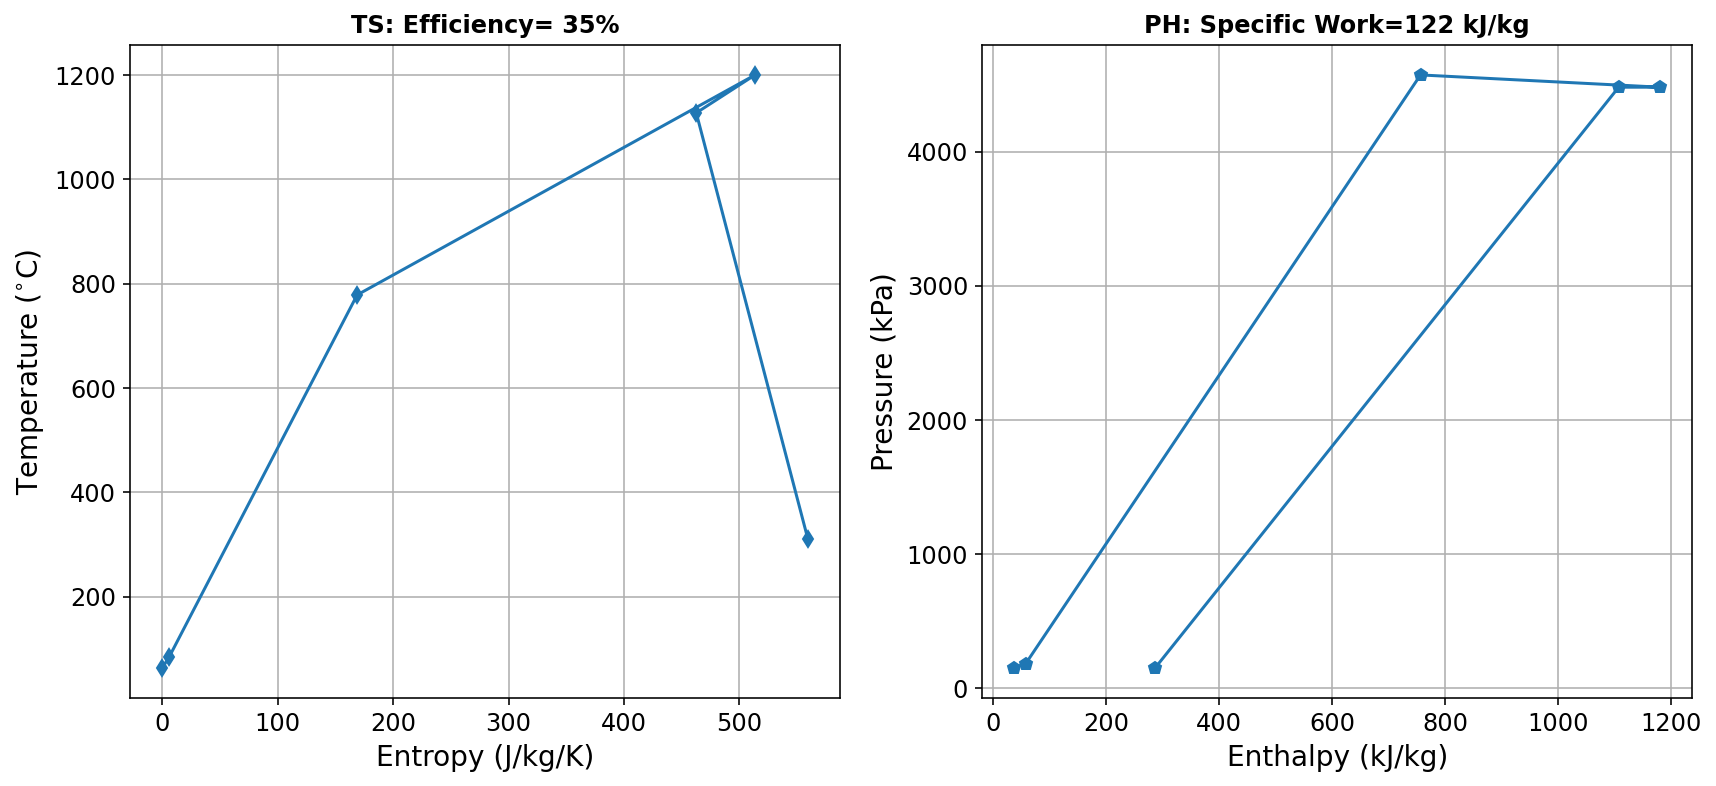

In [60]:
tf = SimpleTurboFan()
tf.cycleDiagrams()

In [51]:
display(tf.statePoints)
display(tf.cycleSummary)

,Temperature (C),Pressure (kPa),Enthalpy (kJ/kg),Entropy (kJ/kg/K),Mach Number
Inlet,63.163200,152.434001,38.342682,-2.842171e-17,0.800000
Fan Exit,83.203326,182.920801,58.477056,5.815207e-03,0.970353
Compressor Exit,778.270930,4573.020029,756.813563,1.688747e-01,NaN
Combustor Exit,1200.000000,4481.559628,1180.526025,5.135207e-01,NaN
Mixed Turbine Inlet,1127.245723,4481.559628,1107.429585,4.626344e-01,NaN
Turbine Exit,310.947949,150.000000,287.292763,5.592426e-01,0.783659


Ambient Temperature (C)                      25.000000
Ambient Pressure (kPa)                      100.000000
Inlet Mach Number                             0.800000
Fan Pressure Ratio                            1.200000
Bypass Ratio                                  6.049372
Overall Pressure Ratio                       30.000000
Turbine Inlet Temperature (C)              1200.000000
Turbine Metal Temperature (C)               900.000000
Stanton Number                                0.070000
Turbine Cooling / Inlet Mass Flow Ratio       0.172514
ND Thrust                                     1.603344
Fan / Total Thrust                            0.816685
Overall Efficiency                            0.350677
Thermal Efficiency                            0.347389
Propulsive Efficiency                         1.009464
dtype: float64

In [61]:
tf.optimize()
display(tf.statePoints)
display(tf.cycleSummary)

FPR = 1.2, OPR=30.0, TIT (K)=1473.15
inefficiency = 0.6493228196072447 

FPR = 1.2000000178813934, OPR=30.0, TIT (K)=1473.15
inefficiency = 0.6493228172618322 

FPR = 1.2, OPR=30.000000447034836, TIT (K)=1473.15
inefficiency = 0.6493228230224957 

FPR = 1.2, OPR=30.0, TIT (K)=1473.1500219516456
inefficiency = 0.6493228134489335 

FPR = 1.2, OPR=30.0, TIT (K)=1473.15
FPR = 1.2000000178813934, OPR=30.0, TIT (K)=1473.15
FPR = 1.2, OPR=30.000000447034836, TIT (K)=1473.15
FPR = 1.2, OPR=30.0, TIT (K)=1473.1500219516456
FPR = 1.2424052114610489, OPR=29.99696477085039, TIT (K)=1473.1500549440414
inefficiency = 0.6438580147695296 

FPR = 1.2424052299743291, OPR=29.99696477085039, TIT (K)=1473.1500549440414
inefficiency = 0.6438580124442105 

FPR = 1.2424052114610489, OPR=29.996965217839996, TIT (K)=1473.1500549440414
inefficiency = 0.6438580178721385 

FPR = 1.2424052114610489, OPR=29.99696477085039, TIT (K)=1473.1500768956878
inefficiency = 0.6438580091047965 

FPR = 1.2424052114610489, OPR=2

,Temperature (C),Pressure (kPa),Enthalpy (kJ/kg),Entropy (kJ/kg/K),Mach Number
Inlet,63.163200,152.434001,38.342682,-2.842171e-17,0.800000
Fan Exit,85.474908,186.619035,60.759321,6.453624e-03,0.987756
Compressor Exit,649.713295,3105.877232,627.651321,1.489010e-01,NaN
Combustor Exit,1200.595595,3043.759687,1181.124421,6.249831e-01,NaN
Mixed Turbine Inlet,1154.282726,3043.759687,1134.593742,5.929033e-01,NaN
Turbine Exit,384.805376,150.000000,361.497541,6.788710e-01,0.783659


Ambient Temperature (C)                      25.000000
Ambient Pressure (kPa)                      100.000000
Inlet Mach Number                             0.800000
Fan Pressure Ratio                            1.224261
Bypass Ratio                                  9.198711
Overall Pressure Ratio                       20.375226
Turbine Inlet Temperature (C)              1200.595595
Turbine Metal Temperature (C)               900.000000
Stanton Number                                0.070000
Turbine Cooling / Inlet Mass Flow Ratio       0.084070
ND Thrust                                     2.568714
Fan / Total Thrust                            0.854679
Overall Efficiency                            0.388570
Thermal Efficiency                            0.406761
Propulsive Efficiency                         0.955280
dtype: float64

In [34]:
print(tf.BypRatio())

2.6222610454866415
